In [156]:
using DataFrames, MixedModels, Iterators, PyPlot

For each sex, we want to simulate datasets so that, on average, they have

1. a given standardized regression coefficient (denoted $b$) for the Attractiveness predictor (denoted $X$) 
2. a given set of Variance Partitioning Coefficients (VPCs) for the random effects

In this preamble I describe how we can simulate datasets that meet both of these constraints. Then the rest of this notebook gives the Julia code that implements the simulation.

Our model for each sex (note: not the model for the entire dataset after both sexes are combined) looks like
$$
Y = (\beta_0 + u_P + u_T) + (\beta_1 + u_{PX} + u_{TX})X + e,
$$
where $u_P$, $u_T$, $u_{PX}$, and $u_{TX}$ are, respectively, the random participant intercepts, random target intercepts, random participant sloeps, and random target slopes, and they have variances $\sigma^2_P$ and $\sigma^2_T$, $\sigma^2_{PX}$, and $\sigma^2_{TX}$ and zero means. $e$ is a random error term with variance $\sigma^2_E$. All the random effects are assumed to be uncorrelated.

Taking the variance of $Y$ (and treating $X$ as a random variable [independent of $u_{PX}$ and $u_{TX}$] so that we get the total or marginal variance of $Y$) gives
$$
\begin{aligned}
\text{var}(Y) &= \sigma^2_P + \sigma^2_T + \beta_1^2\text{var}(X) + \text{var}(u_{PX}X) + \text{var}(u_{TX}X) + \sigma^2_E
\\ &= \sigma^2_P + \sigma^2_T + \beta_1^2\text{var}(X) + \text{var}(X)\sigma^2_{PX} + \sigma^2_{PX}\bar{X}^2 + \text{var}(X)\sigma^2_{TX} + \sigma^2_{TX}\bar{X}^2 + \sigma^2_E.
\end{aligned}
$$
Now to implement constraint \#1 from above, we assume both $X$ and $Y$ are standardized, in which case $\beta_1 = b$, that is, the unstandardized regression coefficient and standardized regression coefficient are identical. Then we can simplify this variance equation into the form
$$
1 - b^2 = \sigma^2_P + \sigma^2_T + \sigma^2_{PX} + \sigma^2_{TX} + \sigma^2_E. \tag{1}
$$
So in order for us to generate a dataset with a particular standardized regression coefficient $b$, we just have to set the parameters of the true model so that they satisfy Equation 1.

For constraint \#2, first note that the VPC for a particular random effect $u$ with variance $\sigma^2$ is defined as the proportion of $\text{var}(Y|X)$ that is due to $u$, so that under the assumptions given above,
$$
VPC(u) = \frac{\sigma^2}{\sigma^2_P + \sigma^2_T + \sigma^2_{PX} + \sigma^2_{TX} + \sigma^2_E}.
$$
Substiting Equation 1 into the above and solving for $\sigma^2$ gives
$$
\sigma^2 = (1 - b^2)VPC(u). \tag{2}
$$

What this all says is that we can simulate datasets separately for each sex with a particular standardized regression coefficient and set of VPCs (on average) by (1) generating X to have mean=0 and variance=1, (2) setting $\beta_1$ to the desired value $b$, (3) setting the variances of the random effects according to Equation 2. Then we can stack the two datasets and fit the model
$$
Y = (\beta_0 + u_P + u_T) + (\beta_1 + u_{PX} + u_{TX})X + \beta_2Z + \beta_3XZ + e,
$$
where $Z$ is a contrast coded predictor with values -0.5 for one sex and +0.5 for the other. Then the coefficient $\beta_3$ gives the difference in standardized regression coefficients for the Attractiveness predictor ($X$) between the two sexes.

For the equivalence test power simulation, we let both sexes have standardized regression coefficients of 0.3 and define the equivalence region to be $|\hat{\beta}_3| < 0.1$. The number of participants is set somewhere between 100 and 2000, varying uniformly on the log scale.

For the significance test power simulation, we let the two sexes have standardized regression coefficients of 0.3 vs. 0.4, so that $\beta_3 = 0.1$. The number of participants is set somewhere between 50 and 1000, varying uniformly on the log scale.

In both cases, we set the number of targets to 592 and the VPCs to the defaults from the [WKJ 2014 power app](http://jakewestfall.org/power/), which are
$$
VPC_E = 0.4, VPC_P = 0.2, VPC_T = 0.2, VPC_{PX} = 0.1, VPC_{TX} = 0.1.
$$
Note that $VPC_E$ is 0.4 and not 0.3 because it has the variance of the participant-by-target interaction effects (which have a VPC of 0.1) implicity added to it.

# Define the simulation functions

In [66]:
function make_df(n::Int64, m::Int64, b::Float64)
    # set up data frame
    dat = collect(product(collect(1:n), collect(1:m)))
    dat = DataFrame(subj=[i[1] for i in dat], stim=[i[2] for i in dat])
    dat[:attract] = randn(n*m)

    # add subject effects
    subj_dat = DataFrame(
        subj=collect(1:n),
        subj_intercept=randn(n)*sqrt(.2*(1-b^2)),
        subj_slope=randn(n)*sqrt(.1*(1-b^2)))
    dat = join(dat, subj_dat, on=:subj)

    # add stimulus effects
    stim_dat = DataFrame(
        stim=collect(1:m),
        stim_intercept=randn(m)*sqrt(.2*(1-b^2)),
        stim_slope=randn(m)*sqrt(.1*(1-b^2)))
    dat = join(dat, stim_dat, on=:stim)

    # add response
    dat[:Y] = (dat[:subj_intercept] + dat[:stim_intercept]) +
          (b + dat[:subj_slope] + dat[:stim_slope]).*dat[:attract] +
          randn(n*m)*sqrt(.4*(1-b^2))

    return dat
end

make_df (generic function with 2 methods)

In [99]:
function sim(n::Int64, m::Int64, b::Array{Float64,1}, kind::Int64)
    # b = array of 2 slopes
    # kind: 1 = significance, 2 = equivalence
    
    width = [1.959964, 1.644854]
    
    # create separate datasets
    dat1 = make_df(div(n,2), div(m,2), b[1])
    dat2 = make_df(div(n,2), div(m,2), b[2])
    dat2[:subj] += div(n,2)
    dat2[:stim] += div(m,2)
            
    # stack the datasets
    dat1[:sex] = -.5
    dat2[:sex] = .5
    dat = [dat1; dat2]
    
    # fit the model
    res = fit!(lmm(@formula(Y ~ attract*sex + (attract|subj) + (attract|stim)), dat))
    ci1 = fixef(res)[4] - width[kind]*stderr(res)[4]
    ci2 = fixef(res)[4] + width[kind]*stderr(res)[4]
    
    significant = (ci1 > 0) || (ci2 < 0)
    equivalent = (ci1 > -.1) & (ci2 < .1)
    return [significant, equivalent][kind]
end

sim (generic function with 2 methods)

### estimate the time it will take to complete the full simulation

In [163]:
x = linspace(100, 2000, 10)
time_sim(n) = @elapsed sim(convert(Int64, round(n)), 592, [.3, .3], 2)
times = map(n -> time_sim(n), x)

10-element Array{Float64,1}:
  1.10736
  4.09962
  9.80336
 16.3663 
 50.3909 
 26.7308 
 32.9139 
 34.3602 
 40.1057 
 64.2408 

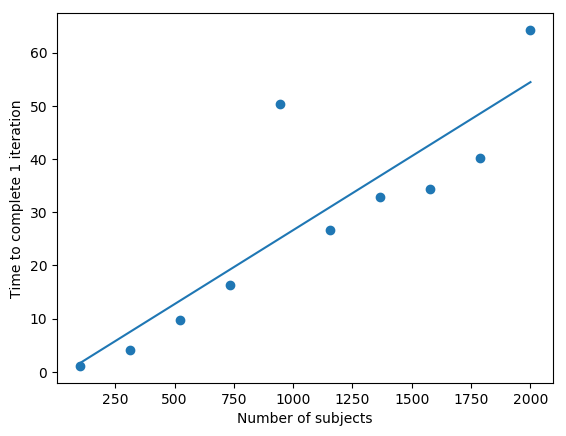

In [165]:
a, b = linreg(x, times)
scatter(x, times)
plot([100, 2000], [a + b*100, a + b*2000])
xlabel("Number of subjects")
ylabel("Time to complete 1 iteration");

In [167]:
n_iter = 2000
full_x = round(exp(linspace(log(100/2), log(2000/2), n_iter)))*2
print("estimated time: ", sum(a + b*full_x)/60/60, " hours")

estimated time: 9.139648798829212 hours

# Simulate!

In [176]:
@time equivalent = map(n -> sim(convert(Int64, n), 592, [.3, .3], 2), full_x);

45278.056323 seconds (14.82 G allocations: 1.166 TB, 2.18% gc time)


In [177]:
n_iter = 1000
sig_x = round(exp(linspace(log(50/2), log(1000/2), n_iter)))*2
@time significant = map(n -> sim(convert(Int64, n), 592, [.3, .4], 1), sig_x);

11828.182593 seconds (3.77 G allocations: 309.041 GB, 2.50% gc time)


# Save results

In [185]:
writetable("equivalent.csv", DataFrame(x=full_x, y=convert(Array{Int64,1}, equivalent)))

In [187]:
writetable("significant.csv", DataFrame(x=sig_x, y=convert(Array{Int64,1}, significant)))